TO DO:
- Try dimensionality reduction before clustering
- Analyze sub clusters and look at their performance 
- Review proposal to make sure following
- Change metric when calculating clusters (currently ward) 
- check with professor that euclidean makes sense because tf-idf is normalized   
- Then pivot to SVD method 

In [1]:
%reset -f

In [2]:
!pip install nltk
!pip install sklearn
!pip install gensim
!pip install matplotlib
!pip install networkx

In [3]:
import nltk
from nltk.corpus import reuters
import re
import numpy as np
import pandas as pd
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import sklearn
from scipy.cluster.hierarchy import dendrogram, linkage, ward, fcluster
import networkx as nx
import collections
import math
import operator
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gimli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Data

In [4]:
# Extract fileids from the reuters corpus
fileids = reuters.fileids()

# Initialize empty lists to store categories and raw text
categories = []
text = []

# Loop through each file id and collect each files categories and raw text
for file in fileids:
    categories.append(reuters.categories(file))
    text.append(reuters.raw(file))

# Combine lists into pandas dataframe. reutersDf is the final dataframe. 
og = pd.DataFrame({'ids':fileids, 'categories':categories, 'text':text})

In [5]:
df = og.copy()

### Text Processing

In [6]:
# processing text
df.text = df.text.str.replace('\n', ' ')
df.text = df.text.str.replace('&lt;', '<')
df.text = df.text.str.replace("&amp;", "&")

# down case all
df.text = df.text.str.lower()

# remove symbols
df.text = df.text.str.replace('<', ' ')
df.text = df.text.str.replace('>', ' ')
df.text = df.text.str.replace('-', ' ')

# remove punctuation
df.text = df.text.apply(lambda row: row.translate(str.maketrans('','',string.punctuation)))

# expand abbreviations
#df.text = df.text.str.replace(' qtr ', ' quarter ')
#df.text = df.text.str.replace(' pct ', ' percent ')
#df.text = df.text.str.replace(' jan ', ' janurary ')
#df.text = df.text.str.replace(' feb ', ' february ')
#df.text = df.text.str.replace(' mar ', ' march ')
#df.text = df.text.str.replace(' apr ', ' april ')
#df.text = df.text.str.replace(' may ', ' may ')
#df.text = df.text.str.replace(' jun ', ' june ')
#df.text = df.text.str.replace(' jul ', ' july ')
#df.text = df.text.str.replace(' aug ', ' august ')
#df.text = df.text.str.replace(' sep ', ' september ')
#df.text = df.text.str.replace(' oct ', ' october ')
#df.text = df.text.str.replace(' nov ', ' november ')
#df.text = df.text.str.replace(' dec ', ' december ')
#df.text = df.text.str.replace(' bil ', ' billion ')
#df.text = df.text.str.replace(' mln ', ' million ')

df.text = df.text.str.replace(' qtr ', ' ')
df.text = df.text.str.replace(' pct ', ' ')
df.text = df.text.str.replace(' jan ', ' ')
df.text = df.text.str.replace(' feb ', ' ')
df.text = df.text.str.replace(' mar ', ' ')
df.text = df.text.str.replace(' apr ', ' ')
df.text = df.text.str.replace(' may ', ' ')
df.text = df.text.str.replace(' jun ', ' ')
df.text = df.text.str.replace(' jul ', ' ')
df.text = df.text.str.replace(' aug ', ' ')
df.text = df.text.str.replace(' sep ', ' ')
df.text = df.text.str.replace(' oct ', ' ')
df.text = df.text.str.replace(' nov ', ' ')
df.text = df.text.str.replace(' dec ', ' ')
df.text = df.text.str.replace(' bil ', ' ')
df.text = df.text.str.replace(' mln ', ' ')

# go to acronyms so recognized as one concept/token
df.text = df.text.str.replace('united states', 'us')
df.text = df.text.str.replace('new zealand', 'nz')
df.text = df.text.str.replace('hong kong', 'hk')
df.text = df.text.str.replace('united kingdom', 'uk')
df.text = df.text.str.replace('dlrs', 'dollars')

# remove common words that are effectively stop words
df.text = df.text.str.replace('million', '')
df.text = df.text.str.replace('billion', '')
df.text = df.text.str.replace(' quarter ', ' ')
df.text = df.text.str.replace(' percent ', ' ')
df.text = df.text.str.replace(' january ', ' ')
df.text = df.text.str.replace(' february ', ' ')
df.text = df.text.str.replace(' march ', ' ')
df.text = df.text.str.replace(' april ', ' ')
df.text = df.text.str.replace(' may ', ' ')
df.text = df.text.str.replace(' june ', ' ')
df.text = df.text.str.replace(' july ', ' ')
df.text = df.text.str.replace(' august ', ' ')
df.text = df.text.str.replace(' september ', ' ')
df.text = df.text.str.replace(' october ', ' ')
df.text = df.text.str.replace(' november ', ' ')
df.text = df.text.str.replace(' december ', ' ')
df.text = df.text.str.replace(' said ', ' ')
df.text = df.text.str.replace(' janurary ', ' ')
df.text = df.text.str.replace(' decembers ', ' ')

df.text = df.text.str.replace(' rate ', ' ') ## is this valid to remove?
df.text = df.text.str.replace(' year ', ' ')
df.text = df.text.str.replace(' month ', ' ')


# remove all number 
    # originally removing number words
df.text = df.text.apply(lambda row: re.sub('\d*', '', row))

In [7]:
df_retail = df[df.categories.map(set(['retail']).issubset)] # subset to start with 
df_retail = df_retail.reset_index()

In [8]:
### done by tfidfvectorizer
# tokenize words
#df['tokens'] = df.text.apply(lambda row: nltk.word_tokenize(row))
# remove stopwords
#df.tokens = df.tokens.apply(lambda row: [w for w in row if not w in stopwords.words('english')])

# stemming? Maybe for clutering, but not for finding common words. 

## Tf-Idf Matrix

In [9]:
# tfidf. stop word removal. word tokenizer. 
tfidf = TfidfVectorizer(stop_words = 'english', analyzer = 'word')
m = tfidf.fit_transform(df_retail['text'])

In [10]:
# get words and scores in document 0
feature_names = tfidf.get_feature_names() # words 
feature_index = m[0,:].nonzero()[1] # non zero words for first document
tfidf_scores = zip(feature_index, [m[0, x] for x in feature_index]) # scores and words

for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w, s)
    
#tfidf.vocabulary_ 

zayre 0.04385510822857003
woolworth 0.049483152173600504
federated 0.04385510822857003
wal 0.04385510822857003
mart 0.08771021645714006
major 0.03423390355631825
middle 0.04385510822857003
report 0.03676461141068932
beginning 0.049483152173600504
originally 0.03986194750134872
profits 0.04385510822857003
expects 0.04385510822857003
markdowns 0.049483152173600504
lean 0.049483152173600504
kept 0.049483152173600504
inventories 0.03986194750134872
planning 0.049483152173600504
lower 0.08771021645714006
slightly 0.04385510822857003
promotions 0.049483152173600504
agreed 0.03986194750134872
exceptionally 0.04385510822857003
comparison 0.049483152173600504
tougher 0.049483152173600504
decline 0.03423390355631825
cited 0.049483152173600504
mackes 0.049483152173600504
kenneth 0.049483152173600504
hurting 0.049483152173600504
currently 0.049483152173600504
margins 0.04385510822857003
profit 0.04385510822857003
higher 0.027143406738437535
yield 0.049483152173600504
lines 0.049483152173600504
wea

In [11]:
dist = 1 - cosine_similarity(m)
# the diagonals are numbers very close to, but not quite zero (very small negative number)
# problematic for some functions that don't expect negative numbers
for i in range(len(dist)):
    dist[i][i] = 0
    
    
dist_e = euclidean_distances(m)  ## I think its ok to use euclidean because tf-idf normalizes
# euclidean can be innaccurate if documents are different lengths such that vectors are different lengths 
# I would prefer to use euclidean because then more sensicl to calculate centroids
# ask professor?? 

### Hierarchial Clustering

c:\users\gimli\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  
c:\users\gimli\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


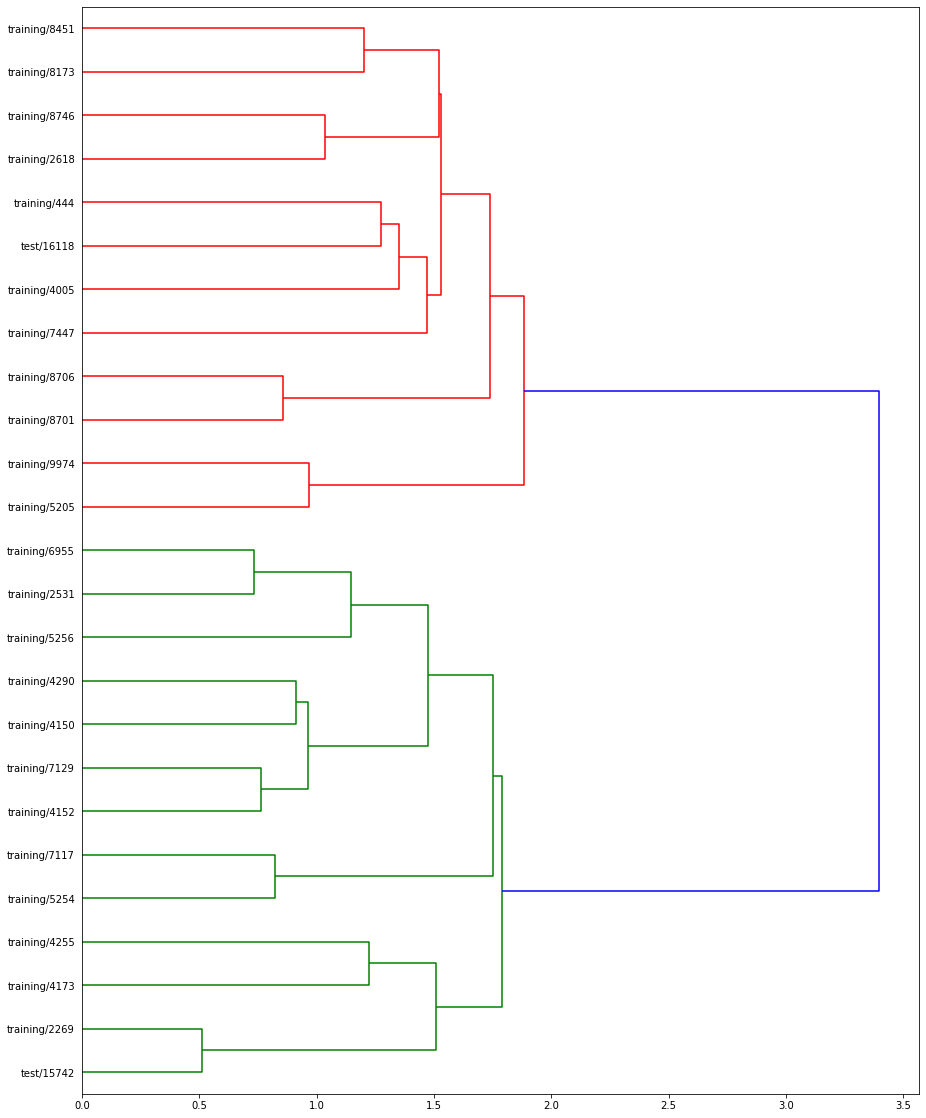

In [12]:
# hieararchial clusters with children 
linkage_matrix = linkage(dist, method = 'ward') # try different methods
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
linkage_matrix_e = linkage(dist_e, method = 'ward') # try different methods

# plot dendogram
fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage_matrix, orientation="right", labels = df_retail.ids.unique())

In [13]:
#score = dict()
#for k in range(2 , min(math.floor(len(df_retail) / 3), 10)): # want min(minimum avg 3 documents per cluster OR 10% docs)
#    f = fcluster(linkage_matrix, k, criterion = 'maxclust')
#    score[k] = sklearn.metrics.silhouette_score(m, f, metric = 'cosine')
    
# cluster number with max score
#k = np.argmax(score) + 2
#k = max(score.items(), key=operator.itemgetter(1))[0] + 2
#f = fcluster(linkage_matrix, k, criterion = 'maxclust')

## this seemingly doesn't calculate silhouette score right....

In [14]:
# https://stackoverflow.com/questions/21638130/tutorial-for-scipy-cluster-hierarchy
# idea for scree plot to determine number of clusters in fcluster using 'maxclust' in criterion

In [15]:
def frame_merge(df, f):
    # merge in with original data via pandas
    frameh = pd.DataFrame(df.index, index = [f], columns = ['index_retail'])
    frameh = pd.merge(frameh, df, right_index = True, left_on = 'index_retail')
    frameh['cluster'] = frameh.index.str[0]
    frameh = frameh.reset_index()
    return frameh

In [16]:
def centroid_label(frameh, m):
    # most common words in clusters (based on tf-idf not just frequency)
    centroid = dict()
    labels = []
    for c in list(frameh.cluster.unique()):
        print()
        # most common words
        cluster1 = list(frameh[frameh.cluster == c].index.unique())
        # find documents cluster
        m1 = m[cluster1,:]
        # take mean vector among all documents
        m1 = m1.mean(axis = 0)
        # record mean vector: centroids of each sub cluster
        centroid[c] = m1

        # max values in mean vector 
        lst = []

        for i in np.argsort(np.asarray(m1)[0])[::-1][:6]:
            lst.append(feature_names[i])

        labels.append(lst)
        
    return labels, centroid

In [17]:
def silhouette_individ(frameh):
    sil_a = dict()
    for c in list(frameh.cluster.unique()):
        sil_a[c] = dict()
        docs_i = list(frameh[frameh.cluster == c].index.unique())
        for i in docs_i:
            lst = []
            for j in docs_i: 
                if i != j:
                    lst.append(np.linalg.norm(m[i].toarray()-m[j].toarray()))
            sil_a[c][i] = np.mean(lst)

    sil_b = dict()
    for c in list(frameh.cluster.unique()):
        sil_b[c] = dict()
        docs_in = list(frameh[frameh.cluster == c].index.unique())
        docs_out = list(frameh[frameh.cluster != c].index.unique())
        for i in docs_in:
            lst = []
            for j in docs_out: 
                lst.append(np.linalg.norm(m[i].toarray()-m[j].toarray()))
            sil_b[c][i] = np.mean(lst)
            
    return sil_a, sil_b

In [18]:
def silhouette_take_avg(sil):
    avg = []
    for v in sil.values():
        avg.append(list(v.values()))
    avg = [item for sublist in avg for item in sublist]
    avg = [0 if math.isnan(i) else i for i in avg]
    avg = np.mean(avg)
    
    return avg

In [19]:
def silhouette_avg(frameh):
    sil_a, sil_b = silhouette_individ(frameh)
    avga = silhouette_take_avg(sil_a)
    avgb = silhouette_take_avg(sil_b)

    return (avgb - avga) / max(avgb, avga)

distortion is only within cluster but is good because can measure rate of change  
silhouette captures within and without cluster

In [20]:
# distortion - sum of squared errors between points and its centroid 
# barely varies with different cluster numbers
distortion = dict()
silhouette = dict()
for k in range(2 , min(math.floor(len(df_retail) / 3), 10)): # want min(minimum avg 3 documents per cluster OR 10% docs)
    f = fcluster(linkage_matrix_e, k, criterion = 'maxclust') ## using euclidean distance 
    frameh = frame_merge(df_retail, f)
    labels, centroid = centroid_label(frameh, m)
    
    # calculate silhouette 
    silhouette[k] = silhouette_avg(frameh)

    # calculate distortion
    sumd = 0
    for i in list(frameh.index.unique()):
        c = int(frameh[frameh.index == i].cluster)
        sumd += np.linalg.norm(m[i]-centroid[c])
        
    # take average 
    distortion[k] = sumd

In [21]:
silhouette # mehhhh just increases as number of clusters increases
# maybe use for evaluation between topics rather than for selection 

{2: 0.06068341039907559,
 3: 0.07751843067782502,
 4: 0.07622047722526229,
 5: 0.09555431064859884,
 6: 0.10956640220636668,
 7: 0.12237298011504162}

In [22]:
# relative rate of change 
roc = []
for k,v in distortion.items(): 
    if k+1 in distortion:
        roc.append(abs(distortion[k+1] - distortion[k]) / distortion[k])

In [23]:
# find k 
for i in range(len(roc)):
    if i == 0:
        continue
    print(i)
    print(abs(roc[i] - roc[i-1]))
    if abs(roc[i] - roc[i-1]) >  .001: # threshold in change of roc 
                                        # tried roc threshold, but magnitude changes for different topics 
        k = i+1 # number of clusters
        break

1
0.004556359183167949


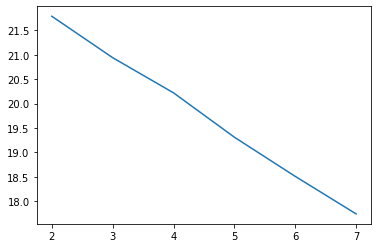

In [24]:
# plot distortion
distortion = sorted(distortion.items()) # sorted by key, return a list of tuples
x, y = zip(*distortion) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.show()

In [50]:
# use this number of clusters to form final clusters
f = fcluster(linkage_matrix, k, criterion = 'maxclust')
frameh = frame_merge(df_retail, f)
labels, centroid = centroid_label(frameh, m)

__Find Documents at Each Level of Hierarchy__

In [26]:
# in linkage matrix, indicate the aggregated node for each node pair
links = pd.DataFrame(linkage_matrix_e) # using euclidean 
links.columns = ['source1', 'source2', 'd', 'n']

links['target'] = 0
n = 24 
for i, row in links.iterrows():
    n += 1
    links.at[i,'target'] = n

In [27]:
# flatten irregular nested lists
def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el

In [28]:
def merge_docs(merge, source):
    merge = pd.merge(merge, merge[['target', 'docs']], left_on = source, right_on = 'target',  how = 'left')
    merge.docs_x = np.where(merge.docs_x.isnull(), '', merge.docs_x)
    merge.docs_y = np.where(merge.docs_y.isnull(), '', merge.docs_y)
    merge['docs'] = merge[['docs_x', 'docs_y']].values.tolist()
    merge = merge.drop(columns = ['docs_x', 'docs_y'])
    #merge.docs = merge.docs.apply(np.ravel)
    merge = merge.rename(columns = {'target_x':'target'})
    merge.docs = list(merge.docs.apply(lambda row: flatten(row)))
    merge.docs = merge.docs.apply(lambda row: [i for i in row if i != ''])

    return merge

In [29]:
# initial merge between frame ids and source1/source2
merge = pd.merge(links, frameh[['ids']], left_on = 'source1', right_index = True, how = 'left')
merge = pd.merge(merge, frameh[['ids']], left_on = 'source2', right_index = True, how = 'left')
# create single docs list column 
merge = merge.rename(columns = {'ids_x':'docs1', 'ids_y':'docs2'})
merge.docs2 = np.where(merge.docs2.isnull(), '', merge.docs2)
merge.docs1 = np.where(merge.docs1.isnull(), '', merge.docs1)
merge['docs']= merge[['docs1', 'docs2']].values.tolist()
merge = merge.drop(columns = ['docs1', 'docs2'])
# flattern docs list column
merge.docs = merge.docs.apply(lambda row: [i for i in row if i != ''])
merge['len'] = merge.docs.apply(lambda row: len(set(row)))

merge1 = merge.copy()

# loop until have one id per document at node (n)
while int(merge[merge.target == merge.target.max()].len) != int(merge[merge.target == merge.target.max()].n): 
    merge = merge_docs(merge, 'source1')
    merge = merge_docs(merge, 'source2')
    merge['len'] = merge.docs.apply(lambda row: len(set(row)))
    
merge.docs = merge.docs.apply(lambda row: set(row))

In [30]:
# create graph reflecting hierarchy
G = nx.DiGraph()
G.add_nodes_from(links.source1)
G.add_nodes_from(links.source2)
G.add_nodes_from(links.target)

subset = links[['source1', 'target']]
G.add_edges_from([tuple(x) for x in subset.values])
subset = links[['source2', 'target']]
G.add_edges_from([tuple(x) for x in subset.values])

In [31]:
# add docs to each target node so know which docs exist at each target 
for i in list(merge.target.unique()):
    G.nodes[i]['docs'] = merge[merge.target == i].docs.values[0]
    
# add docs to origianl nodes as well 
ogdocs = pd.merge(links, frameh[['ids']], left_on = 'source1', right_index = True, how = 'left')
ogdocs = pd.merge(ogdocs, frameh[['ids']], left_on = 'source2', right_index = True, how = 'left')
for i in range(25):
    if len(ogdocs[ogdocs.source1 == i].ids_x) != 0:
        G.nodes[i]['docs'] = ogdocs[ogdocs.source1 == i].ids_x.values[0]
    if len(ogdocs[ogdocs.source2 == i].ids_y) != 0:
        G.nodes[i]['docs'] = ogdocs[ogdocs.source2 == i].ids_y.values[0]

In [32]:
# labels and centroids for every sub cluster 
labelsh = []
centroidh = []
for i in list(range(links.target.max())):
    # most common words
    if i < 25:
        cluster1 = list(frameh[frameh.ids == list(G.nodes[i].values())[0]].index.unique())
    else:
        cluster1 = list(frameh[frameh.ids.isin(list(list(G.nodes[i].values())[0]))].index.unique())
    # find documents cluster
    m1 = m[cluster1,:]
    # take mean vector among all documents
    m1 = m1.mean(axis = 0)
    # record mean vector: centroids of each sub cluster
    centroidh.append(m1)
    
    # max values in mean vector: labels
    lst = []
    for i in np.argsort(np.asarray(m1)[0])[::-1][:3]:
        lst.append(feature_names[i])
        
    labelsh.append(lst)

In [33]:
# find top level clusters and mark as such - determined by fcluster above 
nx.set_node_attributes(G, 0, 'cluster')
for c in list(frameh.cluster.unique()):
    try:
        c_ids = set(frameh[frameh.cluster == c].ids.unique())
        node = [x for x,y in G.nodes(data=True) if y['docs']==c_ids][0]
    except:
        c_ids = frameh[frameh.cluster == c].ids.unique()
        node = [x for x,y in G.nodes(data=True) if y['docs']==c_ids][0]
    G.nodes[node]['cluster'] = c

In [34]:
# labels for top nodes
topnodes = []
for c in list(frameh.cluster.unique()):
    topnodes.append( [x for x,y in G.nodes(data=True) if y['cluster']==c][0])
[labelsh[int(i)] for i in topnodes]

[['sales', 'retail', 'fall'], ['rose', 'orders', 'goods']]

In [35]:
# centroids for the top leve clusters
[centroidh[int(i)] for i in topnodes]

[matrix([[0.        , 0.        , 0.00672299, 0.        , 0.0038064 ,
          0.01404709, 0.00665979, 0.00610475, 0.        , 0.0038064 ,
          0.0091197 , 0.02772066, 0.0034441 , 0.00923203, 0.        ,
          0.00657264, 0.        , 0.0466949 , 0.        , 0.00370806,
          0.00370806, 0.        , 0.03388668, 0.00584075, 0.        ,
          0.02727987, 0.03614042, 0.        , 0.0034441 , 0.03187518,
          0.0038064 , 0.        , 0.00337347, 0.        , 0.        ,
          0.        , 0.0034441 , 0.00665979, 0.        , 0.        ,
          0.        , 0.        , 0.05545183, 0.        , 0.01267083,
          0.01107324, 0.        , 0.01933368, 0.0034441 , 0.00337347,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.0034441 , 0.00893446, 0.01117341, 0.01280379, 0.        ,
          0.01331958, 0.0038064 , 0.        , 0.        , 0.        ,
          0.00370806

In [52]:
# visualization based on distances: x and y coordinates  

###### should use tsne or umap in reality 

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist_e)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [53]:
df_vis = pd.DataFrame(dict(x = xs, y = ys, cluster = f))

In [57]:
cluster_labels = dict()
for i in range(len(f)):
    cluster_labels[i] = labels[i]
    
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

IndexError: list index out of range

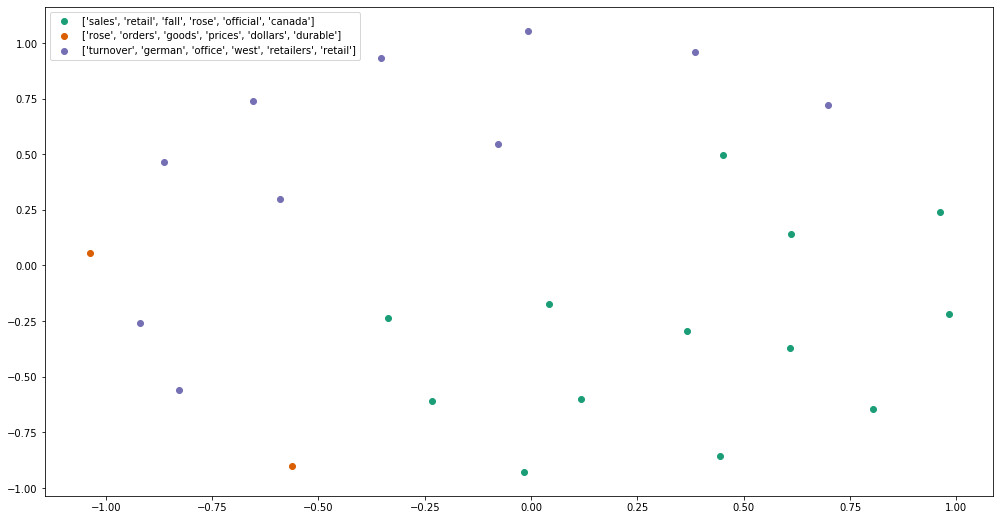

In [56]:
fig, ax = plt.subplots(figsize=(17, 9)) 

df_vis.cluster = df_vis.cluster - 1 # want clusters to start at 0 
groups = df_vis.groupby('cluster')

for name, group in groups:
    ax.scatter(group.x, group.y, c  = cluster_colors[name], label = cluster_labels[name])
    ax.legend()
    
### everything is far apart! curse of dimensionality 

In [ ]:
# kmeans 
# need to research and mess with paramters 
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time km.fit(m)

clusters = km.labels_.tolist()

In [ ]:
# merge in with original data via pandas
frame = pd.DataFrame(df_retail.index, index = [clusters], columns = ['index_retail'])
frame = pd.merge(frame, df_retail, right_index = True, left_on = 'index_retail')
frame['cluster'] = frame.index.str[0]
frame = frame.reset_index()

In [ ]:
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
order_centroids

In [ ]:
frame.cluster.value_counts() # number of documents per cluster 

## http://brandonrose.org/clustering : more info on finding most common words in cluster, visualizing, hierarchial 
# also try taking average of tf-idf per cluster and using that way. 

In [ ]:
# most common words in clusters 

labels = []
for i in range(3):
    # most common words
    cluster1 = list(frame[frame.cluster == i].index.unique())
    # find documents cluster
    m1 = m[cluster1,:]
    # take mean vector among all documents
    m1 = m1.mean(axis = 0)
    # max values in mean vector 
    lst = []

    for i in np.argsort(np.asarray(m1)[0])[::-1][:3]:
        lst.append(feature_names[i])
        
    labels.append(lst)

In [51]:
# visualization based on distances: x and y coordinates  

###### should use tsne or umap in reality 

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist_e)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [39]:
df_vis = pd.DataFrame(dict(x = xs, y = ys, cluster = f))

In [40]:
cluster_labels = dict()
for i in range(len(f)):
    cluster_labels[i] = labels[i]
    
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

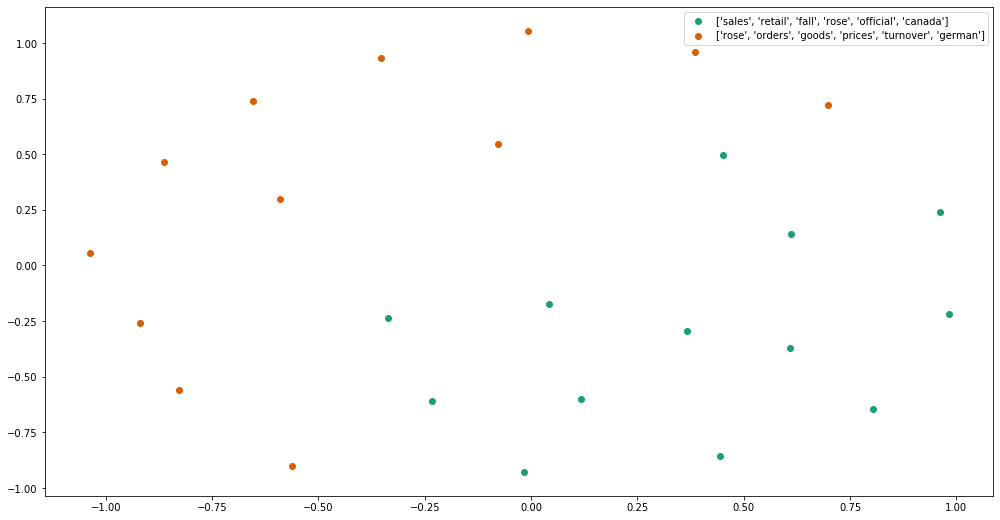

In [49]:
fig, ax = plt.subplots(figsize=(17, 9)) 

groups = df_vis.groupby('cluster')

for name, group in groups:
    ax.scatter(group.x, group.y, c  = cluster_colors[name], label = cluster_labels[name])
    ax.legend()
    
### everything is far apart!

In [ ]:
#svd
# try following lingo algorithm as per paper
u,s,v = np.linalg.svd(m.todense().T, full_matrices = False) # full_matrices make dimensions work. Min(M,N) (why necessary??)
s = np.diag(s)

In [ ]:
m.shape

In [ ]:
cluster1

In [ ]:
x = np.matmul(s,v.T)
np.matmul(u, x)

In [ ]:
# get unique list of topics (categories)
topics = list(df.categories)
topics = [item for sublist in topics for item in sublist]
topics = set(topics)


df[df.categories.map(set(['earn']).issubset)]

df['len'] = df.text.apply(lambda row: len(row))
